In [1]:
import warnings
from operator import itemgetter
import os
from os import path

import numpy as np
from numpy import nan # so eval() with nan works
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

import allen_v1dd.stimulus_analysis.analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups, get_roi_id
from allen_v1dd.stimulus_analysis.dg_models import *
from allen_v1dd.stimulus_analysis.dg_models import plotting
from allen_v1dd.stimulus_analysis.dg_models.config import *

at.set_stylesheet()
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load models and fits
model_config = get_model_config()
models = instantiate_models(model_config)
model_df = load_evaluation_df(models)
fit_df = load_sig_fit_df(models, model_df)

Loading model 1
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 2
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 3
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 4
  Training if necessary...
  Trained and evaluated on 7464 ROIs
Loading model 5
  Training if necessary...
Ignoring 275/276 ROIs in M409828_12_4


M409828_12_4:   0%|          | 0/1 [00:00<?, ?it/s]

Processed 0/1 ROIs in M409828_12_4 (7459 total)
Ignoring 366/367 ROIs in M409828_14_2


M409828_14_2:   0%|          | 0/1 [00:00<?, ?it/s]

Processed 0/1 ROIs in M409828_14_2 (7459 total)
Ignoring 107/109 ROIs in M409828_18_0


M409828_18_0:   0%|          | 0/2 [00:00<?, ?it/s]

Processed 0/2 ROIs in M409828_18_0 (7459 total)
Ignoring 153/154 ROIs in M409828_1a_0


M409828_1a_0:   0%|          | 0/1 [00:00<?, ?it/s]

Processed 0/1 ROIs in M409828_1a_0 (7459 total)
  Trained and evaluated on 7459 ROIs


In [3]:
# Find ROIs best fit by model 5
roi_ids = fit_df.index[fit_df.best_model == 5]
print(len(roi_ids), "ROIs best fit by model 5")

893 ROIs best fit by model 5


In [4]:
fit_df.best_model.value_counts()

None    3276
1       1143
5        893
4        757
3        757
2        638
Name: best_model, dtype: int64

In [57]:
# Test model 5 gradients
X = np.random.randn(20, 14)
y = np.random.randn(len(X))
x0 = np.random.randn(15)

def obj_fn(weights):
    y_pred, y_pred_grad = models[5]._predict(X, weights, return_grad=True)
    return training.rss_loss(y_true=y, y_pred=y_pred, y_pred_grad=y_pred_grad)

scipy.optimize.check_grad(func=lambda w: obj_fn(w)[0], grad=lambda w: obj_fn(w)[1], x0=x0)

2.3526519759487446e-06

In [27]:
pd.isna(fit_df.at["M409828_11_0_89", "model2"])

True

,roi_id,run_gain,run_gain_w,run_gain_f,run_gain_max,size_gain,best_model,lmi,lmi_w,lmi_f,smi
0,M409828_11_1_159,NaN,1.171814,0.861117,1.171814,0.656852,5,NaN,0.079111,-0.074623,-0.207109
1,M409828_11_2_0,3.441995,5.333502,3.387931,5.333502,7.397255,4,0.549752,0.684219,0.544204,0.761827
2,M409828_11_2_1,12.262586,12.332651,2.098055,12.332651,0.216717,4,0.849200,0.849992,0.354434,-0.643768
3,M409828_11_2_15,5.293016,5.117748,0.596974,5.117748,0.590934,5,0.682187,0.673082,-0.252369,-0.257123
4,M409828_11_2_17,NaN,2.674404,0.673757,2.674404,0.237105,5,NaN,0.455694,-0.194917,-0.616677
...,...,...,...,...,...,...,...,...,...,...,...
1645,M409828_1f_0_32,0.112596,0.915101,0.092696,0.915101,8.334299,5,-0.797598,-0.044332,-0.830335,0.785736
1646,M409828_1f_0_69,2.709140,1.893494,4.240152,4.240152,0.446388,5,0.460791,0.308794,0.618332,-0.382754
1647,M409828_1f_0_70,NaN,0.265999,0.285657,0.285657,6.209434,5,NaN,-0.579780,-0.555625,0.722586
1648,M409828_1f_0_74,0.657170,NaN,NaN,NaN,NaN,4,-0.206877,NaN,NaN,NaN


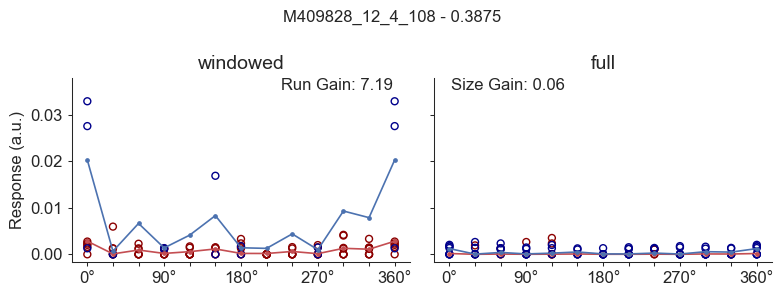

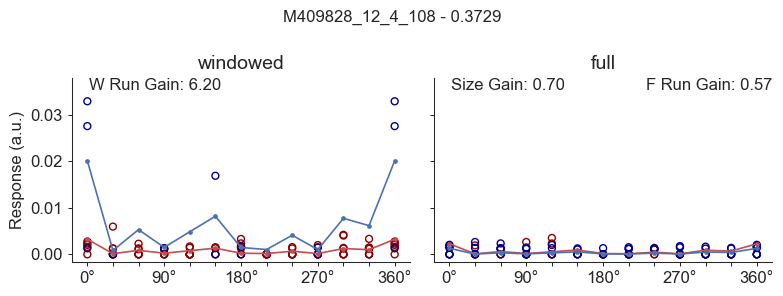

In [45]:
# For ROIs that are fitted by models 4 and 5, plot the score improvement
index_fn = lambda a, b: (a-b)/(a+b)

df = []
# for roi_id in fit_df.index[~fit_df.model4.isna() & ~fit_df.model5.isna() & fit_df.best_model.isin([4, 5])]:
for roi_id in fit_df.index[fit_df.best_model.isin([4, 5])]:
    best_model = fit_df.at[roi_id, "best_model"]
    fit4, fit5 = not pd.isna(fit_df.at[roi_id, "model4"]), not pd.isna(fit_df.at[roi_id, "model5"])
    run_gain = model_df.at[roi_id, "state_model4"][-1] if fit4 else np.nan
    size_gain_model5 = model_df.at[roi_id, "state_model5"][-3] if fit5 else np.nan
    run_gain_w = model_df.at[roi_id, "state_model5"][-2] if fit5 else np.nan
    run_gain_f = model_df.at[roi_id, "state_model5"][-1] if fit5 else np.nan
    df.append(dict(
        roi_id = roi_id,
        run_gain = run_gain,
        run_gain_w = run_gain_w,
        run_gain_f = run_gain_f,
        run_gain_max = max(run_gain_w, run_gain_f),
        size_gain = size_gain_model5,
        best_model = best_model
    ))
df = pd.DataFrame(df)
df["lmi"] = index_fn(df.run_gain, 1)
df["lmi_w"] = index_fn(df.run_gain_w, 1)
df["lmi_f"] = index_fn(df.run_gain_f, 1)
df["smi"] = index_fn(df.size_gain, 1)

roi_ids = np.random.choice(df.roi_id[df.best_model == 4], size=1)

for roi_id in roi_ids:
    for model_key in (4, 5):
        fig, axs = plotting.build_figure(figtitle=f"{roi_id} - {fit_df.at[roi_id, f'model{model_key}']:.4f}", figscale=(4, 3))
        plotting.plot_trial_responses(roi_id, axs)
        
        # wrt = metrics_df.at[roi_id, "frac_resp_trials_w"]
        # frt = metrics_df.at[roi_id, "frac_resp_trials_f"]
        # for ax, rt in zip(axs, (wrt, frt)):
        #     ax.set_title(f"{ax.get_title()} - {rt:.2f}", fontsize=12)
        
        plotting.plot_model_fit(models, model_df, model_key=model_key, roi_id=roi_id, axs=axs)

df

Text(0.5, 0.98, '1650 ROIs whose best fit is either Model 4 or Model 5')

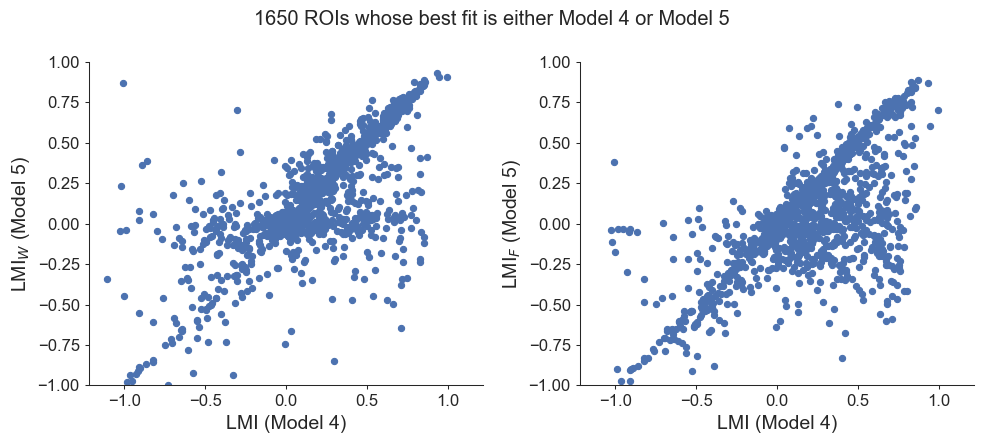

In [32]:
fig, axs = plt.subplots(figsize=(10, 4.5), ncols=2, tight_layout=True)
ax = axs[0]
ax.scatter(x=df.lmi, y=df.lmi_w, s=20)
ax.set_xlabel("LMI (Model 4)")
ax.set_ylabel("LMI$_W$ (Model 5)")

ax = axs[1]
ax.scatter(x=df.lmi, y=df.lmi_f, s=20)
ax.set_xlabel("LMI (Model 4)")
ax.set_ylabel("LMI$_F$ (Model 5)")


for ax in axs:
    ax.axis("equal")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
fig.suptitle(f"{len(df)} ROIs whose best fit is either Model 4 or Model 5")

Text(0.5, 0, 'LMI$_F$ (Model 5)')

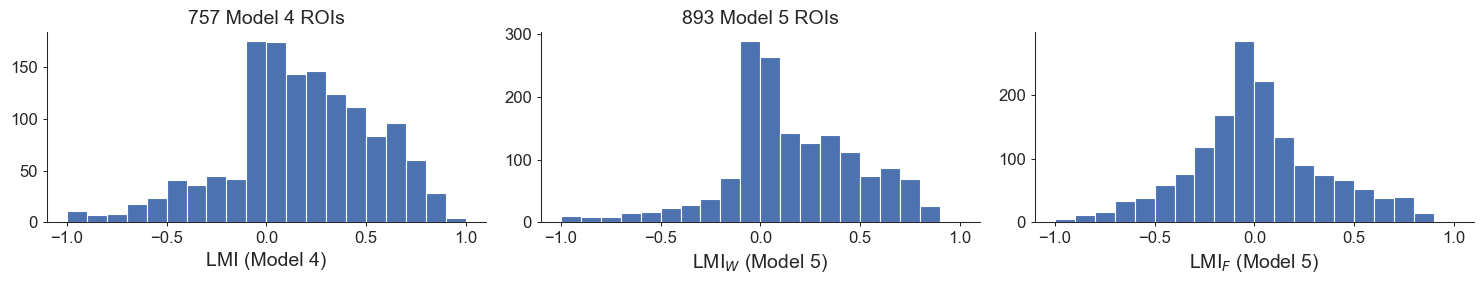

In [34]:
fig, axs = plt.subplots(figsize=(15, 3), ncols=3, tight_layout=True)
bins = np.arange(-1, 1.1, 0.1)

axs[0].hist(x=df.lmi, bins=bins)
axs[0].set_title(f"{len(df[df.best_model == 4])} Model 4 ROIs")
axs[0].set_xlabel("LMI (Model 4)")

axs[1].hist(x=df.lmi_w, bins=bins)
axs[1].set_title(f"{len(df[df.best_model == 5])} Model 5 ROIs")
axs[1].set_xlabel("LMI$_W$ (Model 5)")

axs[2].hist(x=df.lmi_f, bins=bins)
axs[2].set_xlabel("LMI$_F$ (Model 5)")

,roi_id,run_gain,run_gain_w,run_gain_f,run_gain_max,size_gain,best_model,lmi,lmi_w,lmi_f,smi
0,M409828_11_1_159,NaN,1.171814,0.861117,1.171814,0.656852,5,NaN,0.079111,-0.074623,-0.207109
3,M409828_11_2_15,5.293016,5.117748,0.596974,5.117748,0.590934,5,0.682187,0.673082,-0.252369,-0.257123
4,M409828_11_2_17,NaN,2.674404,0.673757,2.674404,0.237105,5,NaN,0.455694,-0.194917,-0.616677
6,M409828_11_2_260,1.277701,1.232551,0.884481,1.232551,0.492920,5,0.121922,0.104164,-0.061300,-0.339656
8,M409828_11_3_1,3.317149,0.384095,3.378934,3.378934,2.246684,5,0.536731,-0.444988,0.543268,0.383987
...,...,...,...,...,...,...,...,...,...,...,...
1643,M409828_1f_0_20,1.841979,0.629156,2.002841,2.002841,2.222030,5,0.296265,-0.227629,0.333964,0.379273
1645,M409828_1f_0_32,0.112596,0.915101,0.092696,0.915101,8.334299,5,-0.797598,-0.044332,-0.830335,0.785736
1646,M409828_1f_0_69,2.709140,1.893494,4.240152,4.240152,0.446388,5,0.460791,0.308794,0.618332,-0.382754
1647,M409828_1f_0_70,NaN,0.265999,0.285657,0.285657,6.209434,5,NaN,-0.579780,-0.555625,0.722586


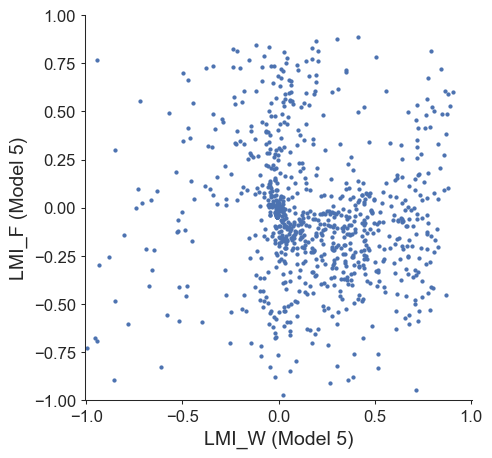

In [35]:
df5 = df[df.best_model == 5]
plt.figure(figsize=(5, 5))
plt.scatter(df5.lmi_w, df5.lmi_f, s=5)
plt.gca().axis("equal")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("LMI_W (Model 5)")
plt.ylabel("LMI_F (Model 5)")

df5

Text(0.5, 0, 'SMI (running) = index(L$_F$*S, L$_W$)')

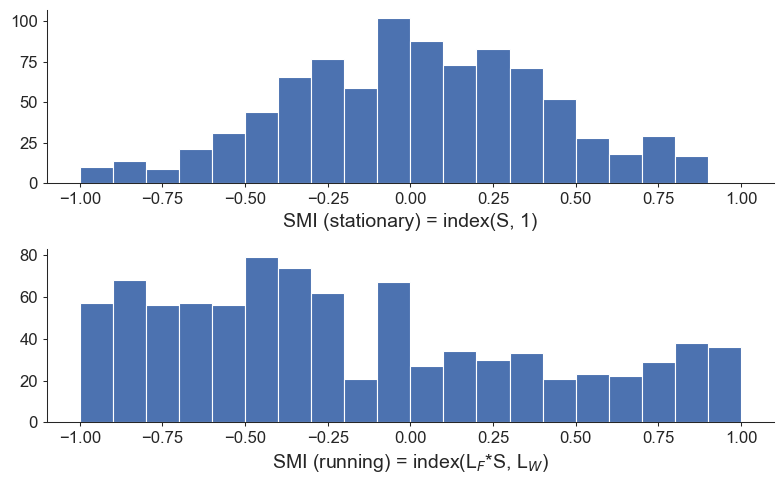

In [36]:
fig, axs = plt.subplots(figsize=(8, 5), nrows=2, tight_layout=True)

ax = axs[0]
ax.hist(df5.smi, bins=bins)
ax.set_xlabel("SMI (stationary) = index(S, 1)")

ax = axs[1]
smi_run = index_fn(df5.run_gain_f * df5.size_gain, df5.run_gain_w)
ax.hist(smi_run, bins=bins)
ax.set_xlabel("SMI (running) = index(L$_F$*S, L$_W$)")

In [38]:
df = pd.read_csv("/Users/chase/Desktop/MindScope/allen_v1dd/data_frames/dg_models/model_5.csv")
df["state"] = df["state"].apply(eval)
gains = np.vstack(df.state.values)[:, 12:]
(gains < 0).mean(axis=0)

array([0.00026813, 0.00214506, 0.00147473])

# Plot sample fits by model 5

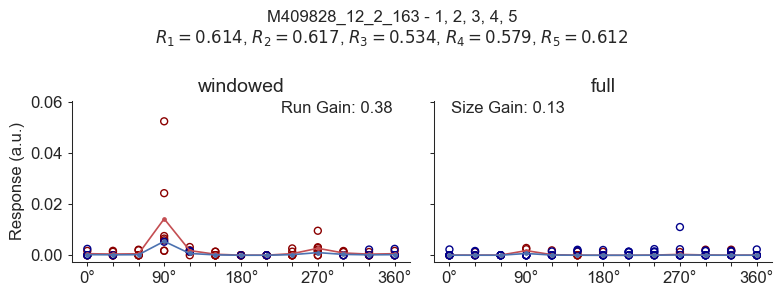

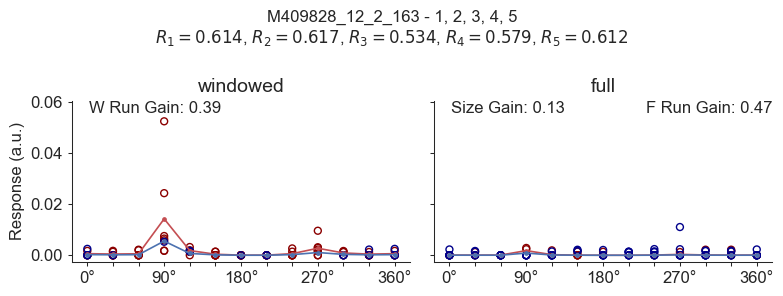

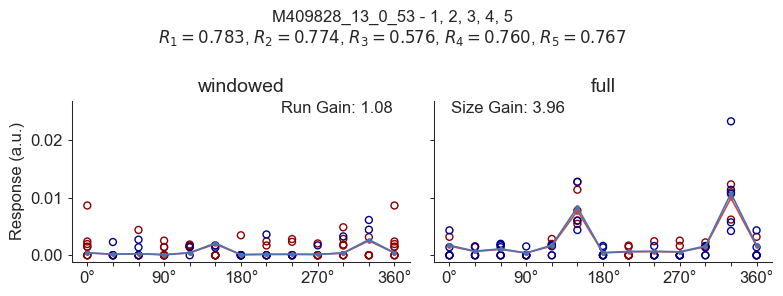

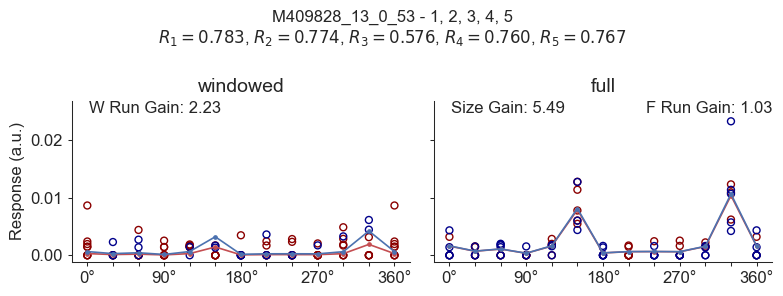

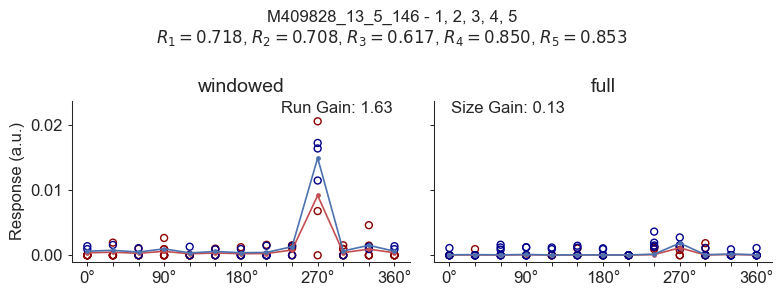

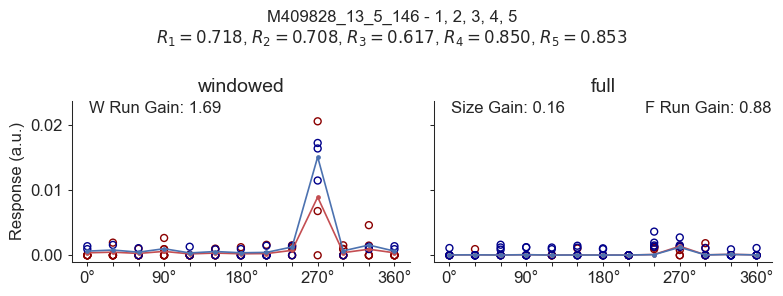

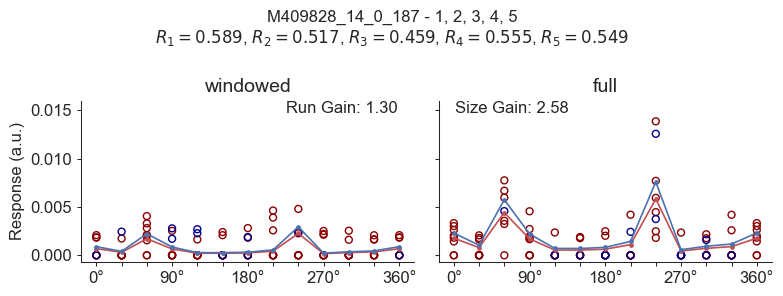

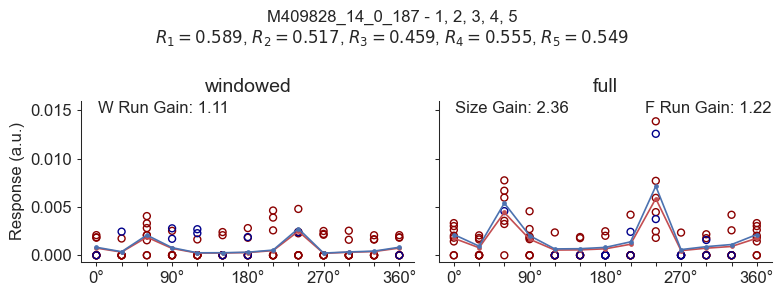

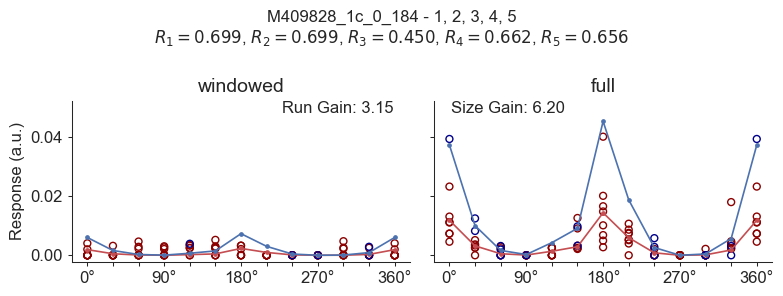

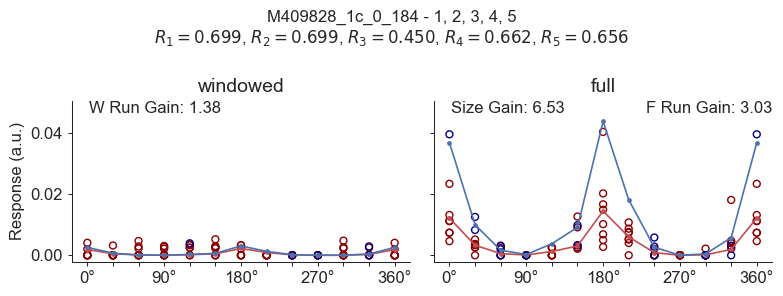

In [42]:
n = 5
x = model_df["r_valid_model5"]
x = x[x > 0.5]
plot_roi_ids = x.index[sorted(np.random.choice(len(x), n, replace=False))]
r_score_keys = [f"r_test_model{m}" for m in models.keys()]

for roi_id in plot_roi_ids:
    r_scores = model_df.loc[roi_id, r_score_keys].values
    r_scores_text = ", ".join([f"$R_{f'{i+1}'} = {r:.3f}$" for i, r in enumerate(r_scores)])

    for model_key in (4, 5):
        fig, axs = plotting.build_figure(figtitle=f"{roi_id} - {fit_df.at[roi_id, 'responsive_models']}\n{r_scores_text}", figscale=(4, 3))
        plotting.plot_trial_responses(roi_id, axs)
        
        # wrt = metrics_df.at[roi_id, "frac_resp_trials_w"]
        # frt = metrics_df.at[roi_id, "frac_resp_trials_f"]
        # for ax, rt in zip(axs, (wrt, frt)):
        #     ax.set_title(f"{ax.get_title()} - {rt:.2f}", fontsize=12)
        
        plotting.plot_model_fit(models, model_df, model_key=model_key, roi_id=roi_id, axs=axs)

In [427]:
df5

,roi_id,run_gain,run_gain_w,run_gain_f,run_gain_max,best_model,lmi,lmi_w,lmi_f
1,M409828_11_2_1,12.262586,19.320192,-2.330272,19.320192,5,0.849200,0.901576,2.503452
2,M409828_11_2_15,5.293016,2.386888,0.557601,2.386888,5,0.682187,0.409487,-0.284026
4,M409828_11_3_18,10.350155,53.583401,-10.682915,53.583401,5,0.823791,0.963359,1.206549
6,M409828_11_3_24,3.275902,7.718230,2.843119,7.718230,5,0.532262,0.770596,0.479589
7,M409828_11_3_5,1.851939,-0.211979,1.899592,1.899592,5,0.298723,-1.538004,0.310248
...,...,...,...,...,...,...,...,...,...
1067,M409828_1e_0_168,4.319992,0.656960,4.134615,4.134615,5,0.624060,-0.207030,0.610487
1068,M409828_1e_0_20,1.093540,0.983270,0.970384,0.983270,5,0.044680,-0.008435,-0.015031
1069,M409828_1e_0_33,2.104116,0.847723,2.077643,2.077643,5,0.355694,-0.082414,0.350152
1071,M409828_1e_0_51,0.956763,0.983336,0.970381,0.983336,5,-0.022096,-0.008402,-0.015032


In [430]:
df5[["run_gain_w", "run_gain_f"]]

,run_gain_w,run_gain_f
1,19.320192,-2.330272
2,2.386888,0.557601
4,53.583401,-10.682915
6,7.718230,2.843119
7,-0.211979,1.899592
...,...,...
1067,0.656960,4.134615
1068,0.983270,0.970384
1069,0.847723,2.077643
1071,0.983336,0.970381


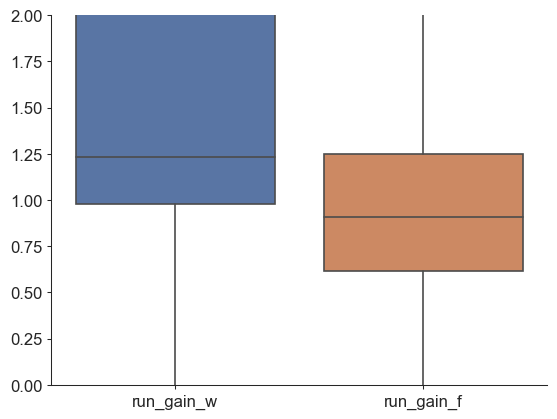

In [43]:
sns.boxplot(data=df5[["run_gain_w", "run_gain_f"]])
plt.ylim(0, 2)
plt.show()

(-1.0, 1.0)

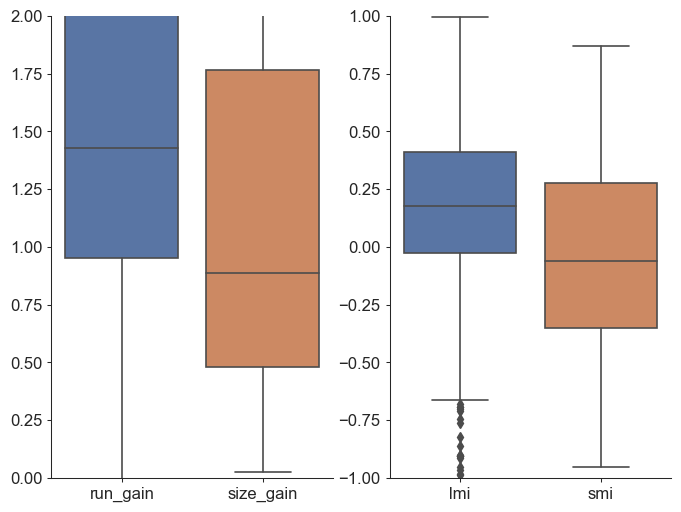

In [50]:
fig, axs = plt.subplots(figsize=(8, 6), ncols=2)
sns.boxplot(data=df[df.best_model == 4][["run_gain", "size_gain"]], ax=axs[0])
axs[0].set_ylim(0, 2)

sns.boxplot(data=df[df.best_model == 4][["lmi", "smi"]], ax=axs[1])
axs[1].set_ylim(-1, 1)

Text(0.5, 0, 'SMI = index(S, 1)')

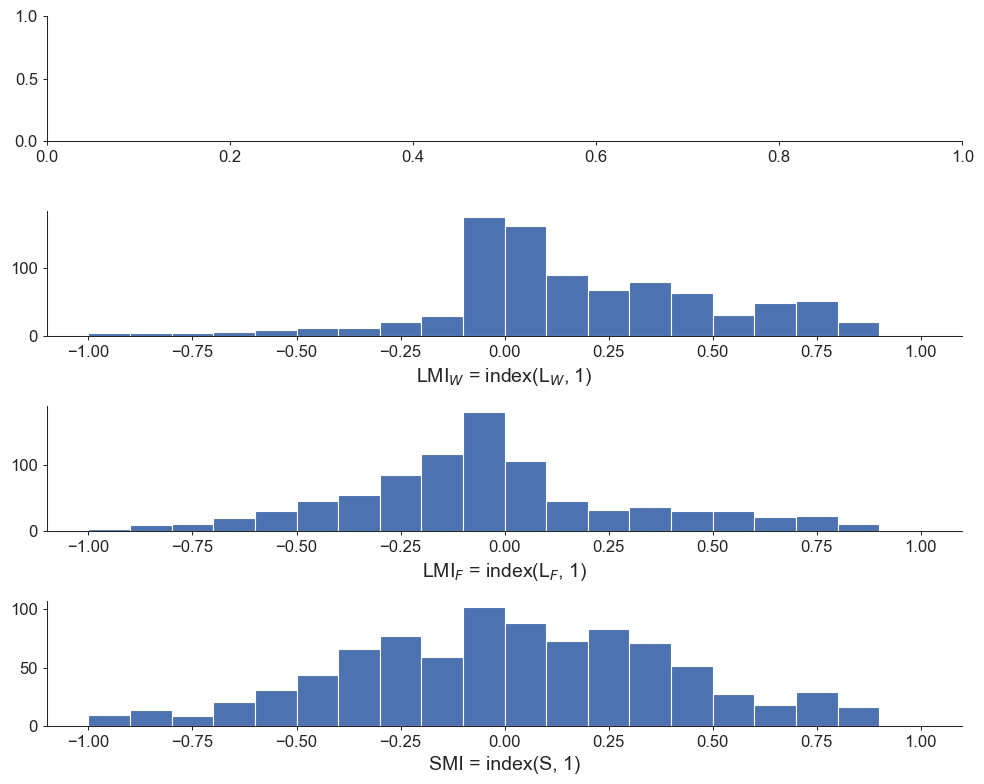

In [53]:
df5 = df[df.best_model == 5]

fig, axs = plt.subplots(figsize=(10, 8), nrows=4, tight_layout=True)
bins = np.arange(-1, 1.1, 0.1)
# axs[0].hist(df5.lmi_avg, bins=bins)
# axs[0].set_xlabel("LMI$_{avg}$ = index((L$_W$ + L$_F$)/2, 1)")

axs[1].hist(df5.lmi_w, bins=bins)
axs[1].set_xlabel("LMI$_W$ = index(L$_W$, 1)")

axs[2].hist(df5.lmi_f, bins=bins)
axs[2].set_xlabel("LMI$_F$ = index(L$_F$, 1)")

axs[3].hist(df5.smi, bins=bins)
axs[3].set_xlabel("SMI = index(S, 1)")

Text(0.5, 1.0, 'MODEL 4: SMI = index(S, 1)')

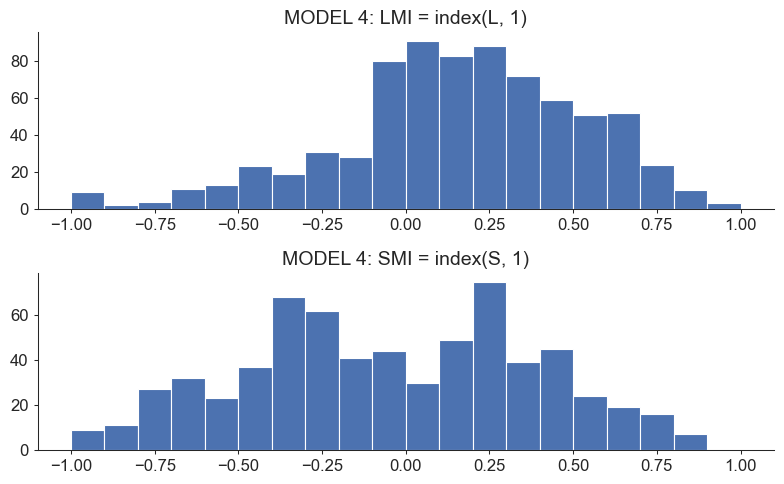

In [54]:
fig, axs = plt.subplots(figsize=(8, 5), nrows=2, tight_layout=True)
bins = np.arange(-1, 1.1, 0.1)
axs[0].hist(df[df.best_model == 4].lmi, bins=bins)
axs[0].set_title("MODEL 4: LMI = index(L, 1)")

axs[1].hist(df[df.best_model == 4].smi, bins=bins)
axs[1].set_title("MODEL 4: SMI = index(S, 1)")

# Running modulated SMI

Text(0.5, 0, 'SMI$_\\mathrm{stat}$ = SMI')

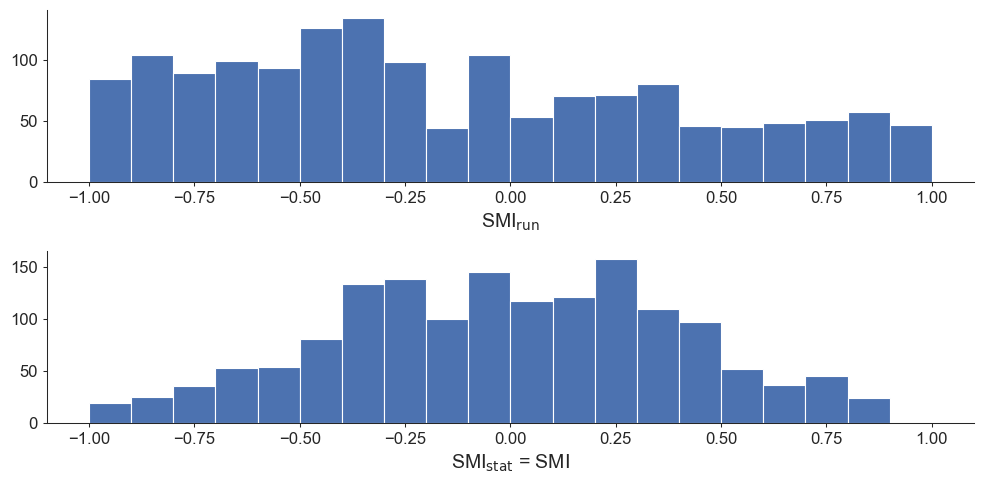

In [57]:
df["smi_run"] = index_fn(df["run_gain_f"] * df["size_gain"], df["run_gain_w"]) # = (DGF run - DGW run) / (DGF run + DGW run)

fig, axs = plt.subplots(figsize=(10, 5), nrows=2, tight_layout=True)
axs[0].hist(df.smi_run, bins=bins)
axs[0].set_xlabel(r"SMI$_\mathrm{run}$")
axs[1].hist(df.smi, bins=bins)
axs[1].set_xlabel(r"SMI$_\mathrm{stat}$ = SMI")

In [58]:
df

,roi_id,run_gain,run_gain_w,run_gain_f,run_gain_max,size_gain,best_model,lmi,lmi_w,lmi_f,smi,smi_run
0,M409828_11_1_159,NaN,1.171814,0.861117,1.171814,0.656852,5,NaN,0.079111,-0.074623,-0.207109,-0.348897
1,M409828_11_2_0,3.441995,5.333502,3.387931,5.333502,7.397255,4,0.549752,0.684219,0.544204,0.761827,0.649053
2,M409828_11_2_1,12.262586,12.332651,2.098055,12.332651,0.216717,4,0.849200,0.849992,0.354434,-0.643768,-0.928885
3,M409828_11_2_15,5.293016,5.117748,0.596974,5.117748,0.590934,5,0.682187,0.673082,-0.252369,-0.257123,-0.871028
4,M409828_11_2_17,NaN,2.674404,0.673757,2.674404,0.237105,5,NaN,0.455694,-0.194917,-0.616677,-0.887267
...,...,...,...,...,...,...,...,...,...,...,...,...
1645,M409828_1f_0_32,0.112596,0.915101,0.092696,0.915101,8.334299,5,-0.797598,-0.044332,-0.830335,0.785736,-0.084462
1646,M409828_1f_0_69,2.709140,1.893494,4.240152,4.240152,0.446388,5,0.460791,0.308794,0.618332,-0.382754,-0.000195
1647,M409828_1f_0_70,NaN,0.265999,0.285657,0.285657,6.209434,5,NaN,-0.579780,-0.555625,0.722586,0.739187
1648,M409828_1f_0_74,0.657170,NaN,NaN,NaN,NaN,4,-0.206877,NaN,NaN,NaN,NaN


Text(0.5, 0, 'Running')

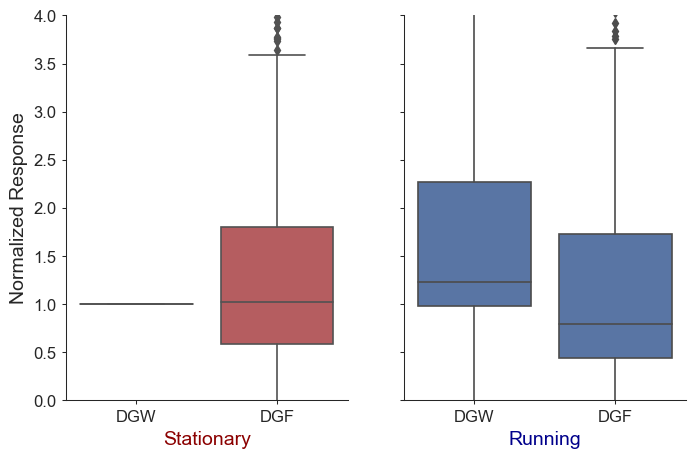

In [68]:
fig, axs = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)

sns.boxplot([np.ones(len(df5)), df5.size_gain], ax=axs[0], color=plotting.STATIONARY_COLOR)
axs[0].set_xticks(ticks=[0, 1], labels=["DGW", "DGF"])
axs[0].set_ylim(0, 4)
axs[0].set_xlabel("Stationary", color=plotting.STATIONARY_COLOR_DARK)
axs[0].set_ylabel("Normalized Response")

run_w, run_f = df5.run_gain_w, df5.size_gain * df5.run_gain_f
sns.boxplot([run_w, run_f], ax=axs[1], color=plotting.RUNNING_COLOR)
axs[1].set_xticks(ticks=[0, 1], labels=["DGW", "DGF"])
axs[1].set_xlabel("Running", color=plotting.RUNNING_COLOR_DARK)

In [70]:
spstats.ttest_rel(run_w, run_f)

TtestResult(statistic=-2.4826076198683626, pvalue=0.01322541224483675, df=892)